# Simulating interacting particles

To get more realistic, we consider case when the particles are interacting.  This is interesting, because we are not able to solve this cas analytically and numerical simulations are required. In our naive implementation, we use purely repulsive soft-core Lennard-Jones potential to describe the interaction:

$$ U=\sum_{r_{ij}<2\sigma}\phi(r_{ij})=\sum_{r_{ij}<2\sigma}4\epsilon\left(\frac{\sigma}{r_{ij}} \right)^{12},\ \ \ \ \mathbf{F}_{i}=-\frac{\partial U}{\partial \mathbf{r}_{ij}} =\sum_{r_{ij}<2\sigma}48\epsilon\left(\frac{\sigma}{r_{ij}} \right)^{12} \frac{\mathbf{r}_{ij}}{r^2_{ij}}$$

$$ \mathbf{r}_{ij} = \mathbf{r}_j - \mathbf{r}_i,\ \ \ r_{ij}=|\mathbf{r}_{ij}| $$

where we sum only over particles at separations less than $2\sigma$ with $\sigma$ particle diameter and $\epsilon$ the potential well depth (measure of strenght of attraction).

First, we import required libraries:

In [1]:
import numpy as np # import numpy library as np
from numpy import newaxis
import matplotlib.pyplot as plt # import pyplot library as plt 
import matplotlib.animation as animation # import animation modules from matplotlib
from mpl_toolkits.mplot3d import Axes3D # import Axes3D from mpl_toolkits.mplot3d
plt.style.use('ggplot') # use "ggplot" style for graphs
% matplotlib nbagg
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\marti\\Miniconda2\\envs\\py36\\Library\\bin\\ffmpeg.exe"
mywriter = animation.FFMpegWriter(fps=30)

define `init` function:

In [2]:
def init():
    global R,V,W,F,Rs,Vs,Ws,time
    initconf() # create random particle configuration R[:,:] without overlaps
    V[:,:] = 0.0# initialize all the variables to zero
    W[:,:] = 0.0
    F[:,:] = 0.0
    Rs[:,:,:] = 0.0
    Rs[0,:,:] = R[:,:] # initial positions
    Vs[:,:,:] = 0.0
    Ws[:,:,:] = 0.0
    time[:] = 0.0
    title.set_text(r'') # initialize title
    line.set_data([],[]) # initialize line to show particle trajecotry
    line.set_3d_properties([]) # extend to 3d
    particles.set_data([], []) # initialize current posiiton for all particles
    particles.set_data([], []) # extend to 3d
    return particles, title, line # return objects to be rendered

define `animate` function with **Leap-Frog** method for increased numerical stability:

$$0 = \mathbf{V}_{i,n-\frac{1}{2}}-\frac{\zeta}{m}\Delta t\frac{1}{2}\left(\mathbf{V}_{i,n+\frac{1}{2}}+\mathbf{V}_{i,n-\frac{1}{2}}\right)  + \frac{1}{m}\mathbf{F}_{i,n}\Delta t + \frac{1}{m} {\Delta \mathbf{W}_n}$$

$$\mathbf{V}_{i,n+\frac{1}{2}} =\left(\left(1-\frac{\zeta}{2m}\Delta t\right)\mathbf{V}_{i,n-\frac{1}{2}} + \frac{1}{m}\mathbf{F}_{i,n}\Delta t + \frac{1}{m} {\Delta \mathbf{W}_n}\right)\left({1+\frac{\zeta}{2m}\Delta t}\right)^{-1}$$
and
$$\mathbf{R}_{i,n+1}=\mathbf{R}_{i,n}+\mathbf{V}_{i,n+\frac{1}{2}} \Delta t$$

In [3]:
def animate(i):
    global R, V, W, F, Rs, Vs, Ws, time
    time[i] = i*dt
    particleforces() # ! exhaustive search over N^2 particles to get interaction force ... "Np hard problem"
    W = std*np.random.randn(nump,dim) # generate zero mean normal displacement with prescribed variance
    
    # Euler scheme for velocity and position time evolution
    #V = V*(1-zeta/m*dt) + W/m + F/m*dt
    # Leap-frog scheme
    V = (V*(1-zeta/m*dt*0.5) + W/m + F/m*dt) / (1+zeta/m*dt*0.5)
    R = R + V*dt
    
    # Runge-Kutta Second order scheme:
#     V1 = V*(1-zeta/m*0.5*dt)
#     V = V-V1*zeta/m*dt + W/m + F_drift/m
#     R = R + V1*dt
    Rs[i,:,:] = R
    Vs[i,:,:] = V
    Ws[i,:,:] = W
    title.set_text(r"t = "+str(time[i])+"/"+str((nums-1)*dt))
    line.set_data(Rs[:i+1,n,0], Rs[:i+1,n,1]) # trace particle up to current time
    line.set_3d_properties(Rs[:i+1,n,2]) # and extend to 3d
    # pbc(.) function applies periodic boundary conditions
    particles.set_data(pbc(R[:,0], box[0]), pbc(R[:,1], box[0])) # render particles
    particles.set_3d_properties(pbc(R[:,2], box[0])) # and extend to 3d
    return particles, title, line # return objects to render

#### Functions for interacting particles
Next we define functions required speicifically for simulation of interacting particles:

In [4]:
def pbc(r, lbox):
    """ Enforce periodic boundary conditions
    
    Parameters:
    -------------
    r:
    lbox:
    
    Returns:
    -------------
    :remainder after division with sign of the dividend
    """
    return np.fmod(r+lbox, lbox)
def distance(r1, r2, lbox):
    """ Compute distance between particles
    
    Accepts single particles, particle vectors and combination therof
    """
    return r2-r1-np.around((r2-r1)/lbox)*lbox
def fij(r2, rij):
    """Calculates force F_ij on particle r_ij
    
    Based on formula F_ij = dU/dr_ij
    
    Parameters:
    ------------
    r2: pow(rij, 2)
    rij: particle position
    
    Returns:
    -------------
    f: Force on particle ij due to purely-repulsive soft core potential
    """
    #f = -24*eps*(2*(r2/sig**2)**(-6) - (r2/sig**2)**(-3)) / r2 * rij ## Full Lenhard jones
    f = -48*eps*((r2/sig**2)**(-6))/r2*rij ## purely repulsive soft-core 
    return f
def particleforces(): # compute particle forces by examining all N^2 pairs
    """ Compute interparticle forces in exhaustive seearch over all pairs
    
    Returns:
    ------------
    F: (global) Vector of forces on all particles p
    
    Notes:
    -----------
    # Later, cane implement Barnes-Hut, three search or such to make it faster!
    """
    global F
    F[:, :] = 0.0
    for p in range(nump):
        rij = distance(R[p,:], R, box)
        rij2 = np.linalg.norm(rij, axis = 1)**2 # pow(rij,2)
        neigh = (rij2 < (2.0*sig)**2) ## T/F for neigbouring particles
        neigh[p] = False # ignore self pair i = j
        F[p, :] = np.sum(fij(rij2[neigh, newaxis], rij[neigh,:]), axis = 0) # total force on particle p=j
    # returns global F
def initconf():
    """Initialize with random particle configuration without overlaps
    """
    global R, V, W, F, Rs, Vs, Ws, time
    for p in range(nump):
        overlap = True
        while overlap:
            R[p, :] = np.random.rand(dim)*box # generate position candidate
            overlap = False
            for l in range(p):
                rij = distance(R[p,:], R[l, :], box) # get distance vector for p-l pair
                rij2 = np.linalg.norm(rij)**2 # pow(rij,2)
                if rij2 < (.9*sig)**2: # threshold at some arbitrary minimal distance
                    overlap = True # stay in while loop

#### Parameters and variables definitions:

In [7]:
dim = 3 # dimensionality of the problem
nump = 100 # number of interacting particles <- keep low
nums = 4096 # number of simulation steps
dt = 0.01 # time increment
F_0 = 0.0 # Optional constant drift term, breaks symmetry
zeta = 1.0
m = 1.0
kBT = 1.0 # set constants to 1.0
std = np.sqrt(2*kBT*zeta*dt) # ~ mmagnitude of random force fluctuation
sig = 1.0 # unit length of interparticle potential
eps = 1.0 # unit energy of interparticle potential
vf = .35 # volume fraction of particles in box
boxl = np.power(nump*np.pi/6/vf, 1/3) # edge length of unit-cell such that vf satisfied
print('Volume fraction =',vf,'  boxl =',boxl) # print vf and boxl
box = np.array([boxl, boxl, boxl])*sig # create box of proper size
np.random.seed(0)
R = np.zeros([nump, dim]) # current position
V = np.zeros([nump, dim]) # current velocity
W = np.zeros([nump, dim]) # ~ current ranmdom force
F = np.zeros([nump,dim]) # rray to store current particle orcces
Rs = np.zeros([nums, nump, dim]) # all positions
Vs = np.zeros([nums, nump, dim]) # all velocities
Ws = np.zeros([nums, nump, dim]) # all random forces
time = np.zeros([nums]) # all times
F_drift = np.zeros([nump, dim])
F_drift[:, 0] = F_0 # apply force along x direction

Volume fraction = 0.35   boxl = 5.30856157665


Run the animation:

<IPython.core.display.Javascript object>


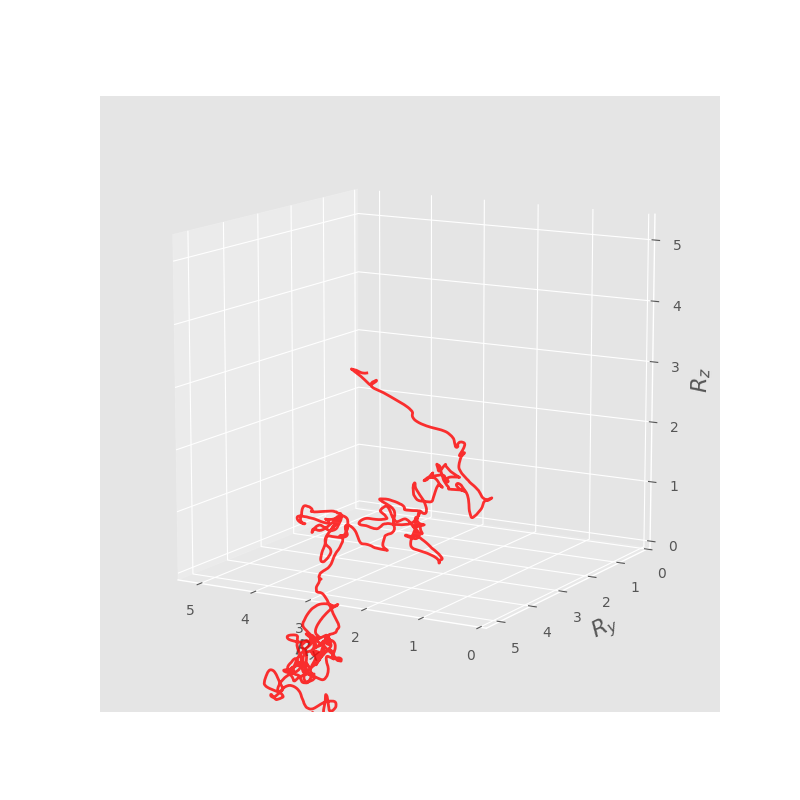

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = "3d")
ax.set_xlabel(r"$R_x$", fontsize=16)
ax.set_ylabel(r"$R_y$", fontsize=16)
ax.set_zlabel(r"$R_z$", fontsize=16) 
ax.set_xlim(0.0, box[0])
ax.set_ylim(0.0, box[1])
ax.set_zlim(0.0, box[2])
ax.view_init(elev=12,azim=120) # set view point
particles, = ax.plot([],[],[], "bo", ms = box[0]//6, alpha = 0.5) # set-up particles ... ms =box[0]//6
# set-up title, posiiton relative to the axes bounding box
title = ax.text(-180.0, 0., 250.0, r'', transform=ax.transAxes, va='center')
line, = ax.plot([],[],[], 'r', lw = 2, alpha = 0.8) # set-up line for tracing single particle
n = 0 # pick particle to track
anim=animation.FuncAnimation(fig,animate,init_func=init,
     frames=nums,interval=5,blit=False,repeat=False) # draw animation
#anim.save('movie.mp4', writer = mywriter, dpi = 400)

### Diffusion constant and Mean Square Displacement

We can use the previously introduced method to check the value of diffusion constant. We expect some deviation from linearity as the Diffusion constant is valid in case of noninteracting particles. Also precison is reduced do to need to simulate only low number of particles due to computational cost in other case.


D = 1.0  (Theoretical)
D = 0.0768896215583  (Simulation via MSD)
Volume fraction = 0.35


<IPython.core.display.Javascript object>


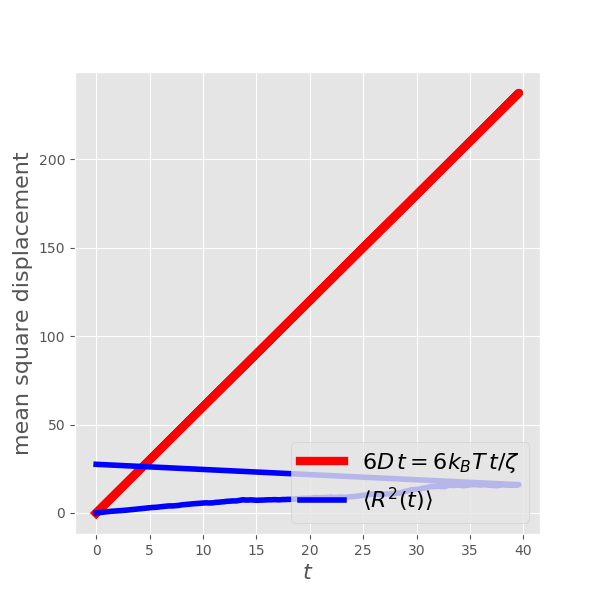

In [9]:
msd = np.zeros([nums]) # mean square displacement
for i in range(nums):
    for p in range(nump):
        msd[i] = msd[i] + np.linalg.norm(Rs[i,p,:] - Rs[0, p, :])**2 # starting position is random
    msd[i] = msd[i] / nump # average over particles
    
D_msd = np.trapz(msd, dx = dt) / (3*(nums*dt)**2)

print('D =',kBT/zeta,' (Theoretical)')
print('D =',D_msd,' (Simulation via MSD)')
print('Volume fraction =',vf) ### print vf
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.set_xlabel(r"$t$", fontsize=16)
ax.set_ylabel(r"mean square displacement", fontsize=16)
ax.plot(time,6*kBT/zeta*time,'r',lw=6, label=r'$6D\,t={6k_BT \,t}/{\zeta}$')
ax.plot(time,msd,'b',lw=4, label=r'$\langle R^2(t)\rangle$')
ax.legend(fontsize=16,loc=4)
plt.show()   

### Characterising the stochastic Process

We can get quantitative charactersitics of the process from autcorrelation and PSD. To visualize this, we use previu=ously developed code:
#### Autocorrelation

<IPython.core.display.Javascript object>


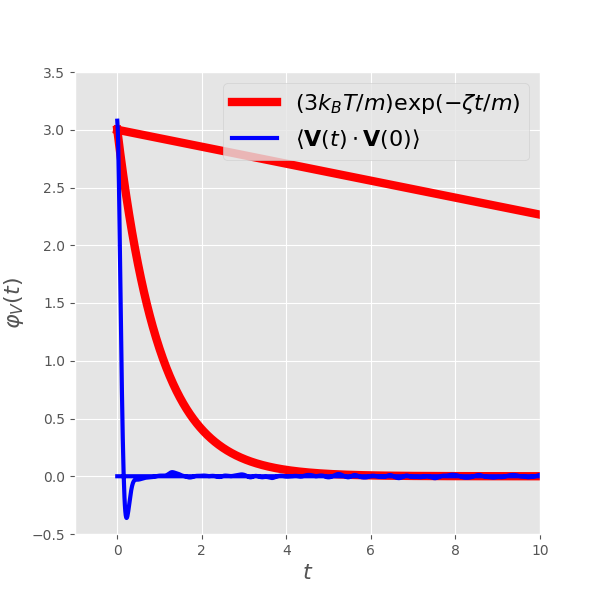

In [10]:
## Compute autocorrelation
def auto_correlate(x, do_scale = False):
    cor = np.correlate(x, x, mode = "full")/len(x) # correlate returns even array [0:2*len(x)-1] centered at len(x)-1
    if do_scale:
        cor = cor / np.var(x)
    return cor[len(x)-1:]

corr = np.zeros([nums])
for p in range(nump):
    for d in range(dim):
        corr = corr + auto_correlate(Vs[:,p,d])
corr = corr /nump # normalize

fig, ax = plt.subplots(1, 1, figsize = (6,6))
exact = (dim*kBT/m*np.exp(-zeta/m*time))
ax.plot(time,exact,'r',lw=6, label=r'$(3k_BT/m)\exp(-\zeta t/m)$')
ax.plot(time,corr,'b',lw=3,label=r'$\langle\mathbf{V}(t)\cdot \mathbf{V}(0)\rangle$')
ax.set_xlabel(r"$t$", fontsize=16)
ax.set_ylabel(r"$\varphi_V(t)$", fontsize=16)
ax.set_xlim(-1,10)
ax.set_ylim(-0.5,3.5)
ax.legend(fontsize=16)
plt.show()

#### Power Spectrum

<IPython.core.display.Javascript object>


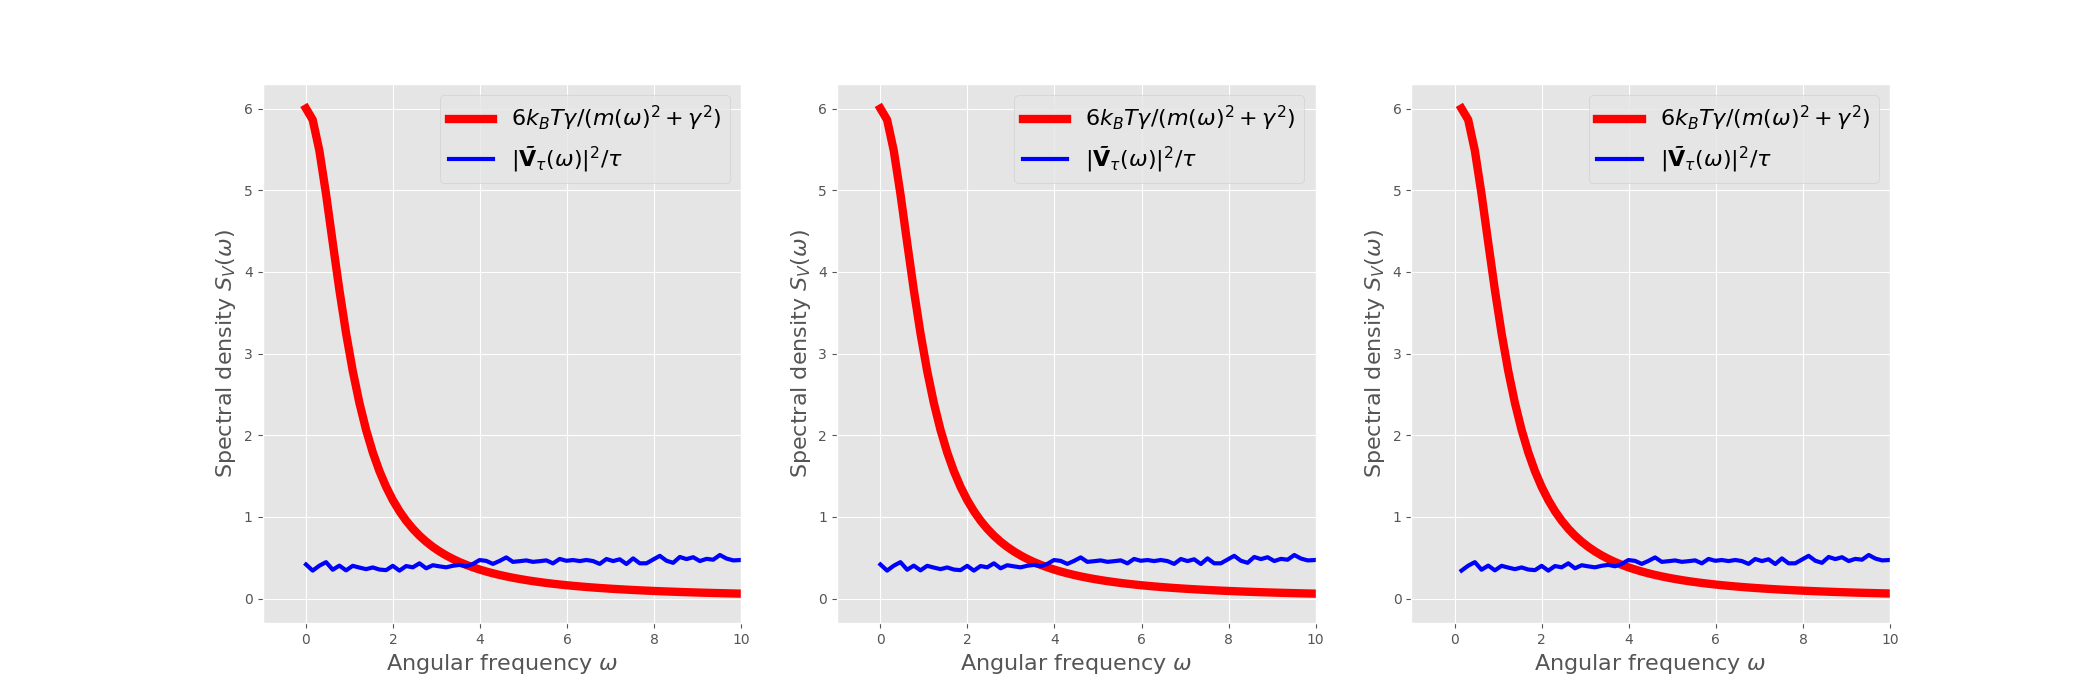

In [11]:
# Alternative #1
from numpy import fft
def psd(x, dt):
    Xw = fft.fft(x)*dt # Fourrier transform
    Sw = np.abs(Xw[:len(x)//2])**2 / (len(x)*dt) # one sided scaled spectral density
    return Sw

Pxx = np.zeros([nums//2])
for p in range(nump):
    for d in range(dim):
        Pxx = Pxx + psd(Vs[:,p,d],dt)
Pxx1 = Pxx / nump # scale for number of particles
freqs = fft.fftfreq(nums, d=dt)[:nums//2]
omegas1 = freqs * 2*np.pi # convert to oemgas

# # Alternative #2
from scipy.fftpack import fft, fftfreq
## https://dsp.stackexchange.com/questions/32187/what-should-be-the-correct-scaling-for-psd-calculation-using-tt-fft
Pxx = np.zeros([nums//2])
for p in range(nump):
    for d in range(dim):
        y = Vs[:,p,d]
        pxx = (np.abs(fft(y)))**2 # get power spectrum, only real
        pxx = pxx[:len(y)//2] / (1/dt *len(y)) # apply scaling (rectangular window function)
        Pxx = Pxx + pxx
Pxx = Pxx / nump
freqs = fftfreq(Vs.shape[0], d = dt)[:Vs.shape[0]//2]
Pxx2 = Pxx[freqs>=0]
freqs = freqs[freqs>=0]
omegas2 = freqs * 2*np.pi

# Alternative # 3
Pxx = np.zeros([nums//2])
from scipy.signal import welch, periodogram
for p in range(nump):
    for d in range(dim):
        freqs, pxx = periodogram(Vs[:,p,d], 1/dt, scaling = 'density', return_onesided = True)
        Pxx = Pxx + pxx[1:]/2 # divide by two for onesided spectrum
Pxx3 = Pxx / nump
omegas3 = freqs[1:] * 2*np.pi

gamma = zeta/m
exact = 6.0*kBT/m*gamma/(omegas1**2 + gamma**2)

fig, axes = plt.subplots(1, 3, figsize=(21,7))

Omegas = [omegas1, omegas2, omegas3]
Pxxs = [Pxx1, Pxx2, Pxx3]
for omegas, Pxx, ax in zip(Omegas, Pxxs, axes):
    ax.plot(omegas,exact,'r',lw=6,label=r'$6k_BT\gamma/(m(\omega)^2+\gamma^2)$')                         
    ax.plot(omegas,Pxx,'b',lw=3,label=r'$|\mathbf{\tilde{V}}_{\tau}(\omega)|^2 / \tau$')
    ax.set_xlabel(r"Angular frequency $\omega$", fontsize=16)
    ax.set_ylabel(r"Spectral density $S_V(\omega)$", fontsize=16)
    ax.legend(fontsize=16)
    ax.set_xlim(-1, 10)
    #plt.ylim(-1, 8)
plt.show()

From the above plots and their comparison with previous results , we can see that with increasing volume fraction, the diffusion coefficient approaches zero. (Note that the particles in animation represent only centroids.) Basically, this means, that random motion is hindered and increasing density  volume fraction). This pehomenon is not yet precisely described nor understood and is reffered to as "Glass transition". 

We also observe that at higher volume fraction, the motion of molecules becomes less predictable from previous states and that the power spectral density becomes more flat, in short, the motion of molecules becomes resemblant of white noise.